# Introduction
This example demonstrates how to create a model to classify speakers from the frequency domain representation of speech recordings, obtained via Fast Fourier Transform (FFT).

It shows the following:

* How to load data, preprocess and feed audio streams into a model
* How to create a 1D convolutional network with residual connections for audio classification.

Our process:

* We prepare a dataset of speech samples from different speakers, with the speaker as label.
* We add background noise to these samples to augment our data.
* We take the FFT of these samples.
* We train a 1D convnet to predict the correct speaker given a noisy FFT speech sample.

Note:

* The noise samples in the dataset need to be resampled to a sampling rate of 16000 Hz before using the code in this example. In order to do this, you will need to have installed ffmpg.

In [1]:
import os
import shutil
import numpy as np

from pathlib import Path
from IPython.display import display, Audio

# Get the data from https://www.kaggle.com/kongaevans/speaker-recognition-dataset/download
# and save it to the 'Downloads' folder in your HOME directory
DATASET_ROOT = "datasets/16000_pcm_speeches"

# The folders in which we will put the audio samples and the noise samples
AUDIO_SUBFOLDER = "audio"
NOISE_SUBFOLDER = "noise"

DATASET_AUDIO_PATH = os.path.join(DATASET_ROOT, AUDIO_SUBFOLDER)
DATASET_NOISE_PATH = os.path.join(DATASET_ROOT, NOISE_SUBFOLDER)

# Percentage of samples to use for validation
VALID_SPLIT = 0.1

# Seed to use when shuffling the dataset and the noise
SHUFFLE_SEED = 43

# The sampling rate to use.
# This is the one used in all of the audio samples.
# We will resample all of the noise to this sampling rate.
# This will also be the output size of the audio wave samples
# (since all samples are of 1 second long)
SAMPLING_RATE = 16000

# The factor to multiply the noise with according to:
#   noisy_sample = sample + noise * prop * scale
#      where prop = sample_amplitude / noise_amplitude
SCALE = 0.5

BATCH_SIZE = 128
EPOCHS = 100

# Data preparation
The dataset is composed of 7 folders, divided into 2 groups:

* Speech samples, with 5 folders for 5 different speakers. Each folder contains 1500 audio files, each 1 second long and sampled at 16000 Hz.
* Background noise samples, with 2 folders and a total of 6 files. These files are longer than 1 second (and originally not sampled at 16000 Hz, but we will resample them to 16000 Hz). We will use those 6 files to create 354 1-second-long noise samples to be used for training.

Let's sort these 2 categories into 2 folders:

* An audio folder which will contain all the per-speaker speech sample folders
* A noise folder which will contain all the noise samples
Before sorting the audio and noise categories into 2 folders,
```
main_directory/
...speaker_a/
...speaker_b/
...speaker_c/
...speaker_d/
...speaker_e/
...other/
..._background_noise_/
```

After sorting, we end up with the following structure:

```
main_directory/
...audio/
......speaker_a/
......speaker_b/
......speaker_c/
......speaker_d/
......speaker_e/
...noise/
......other/
......_background_noise_/
```

In [2]:
# If folder `audio`, does not exist, create it, otherwise do nothing
if os.path.exists(DATASET_AUDIO_PATH) is False:
    os.makedirs(DATASET_AUDIO_PATH)

# If folder `noise`, does not exist, create it, otherwise do nothing
if os.path.exists(DATASET_NOISE_PATH) is False:
    os.makedirs(DATASET_NOISE_PATH)

for folder in os.listdir(DATASET_ROOT):
    if os.path.isdir(os.path.join(DATASET_ROOT, folder)):
        if folder in [AUDIO_SUBFOLDER, NOISE_SUBFOLDER]:
            # If folder is `audio` or `noise`, do nothing
            continue
        elif folder in ["other", "_background_noise_"]:
            # If folder is one of the folders that contains noise samples,
            # move it to the `noise` folder
            shutil.move(
                os.path.join(DATASET_ROOT, folder),
                os.path.join(DATASET_NOISE_PATH, folder),
            )
        else:
            # Otherwise, it should be a speaker folder, then move it to
            # `audio` folder
            shutil.move(
                os.path.join(DATASET_ROOT, folder),
                os.path.join(DATASET_AUDIO_PATH, folder),
            )

# Noise preparation
In this section:

* We load all noise samples (which should have been resampled to 16000)
* We split those noise samples to chuncks of 16000 samples which correspond to 1 second duration each

In [3]:
# Get the list of all noise files
noise_paths = []
for subdir in os.listdir(DATASET_NOISE_PATH):
    subdir_path = Path(DATASET_NOISE_PATH) / subdir
    if os.path.isdir(subdir_path):
        noise_paths += [
            os.path.join(subdir_path, filepath)
            for filepath in os.listdir(subdir_path)
            if filepath.endswith(".wav")
        ]

print(
    "Found {} files belonging to {} directories".format(
        len(noise_paths), len(os.listdir(DATASET_NOISE_PATH))
    )
)

Found 6 files belonging to 2 directories


##### Resample all noise samples to 16000 Hz



* `sudo sh resample_wav.sh` 로 실행

In [4]:
command = (
    "for dir in `ls -1 " + DATASET_NOISE_PATH + "`; do "
    "for file in `ls -1 " + DATASET_NOISE_PATH + "/$dir/*.wav`; do "
    "sample_rate=`ffprobe -hide_banner -loglevel panic -show_streams "
    "$file | grep sample_rate | cut -f2 -d=`; "
    "if [ $sample_rate -ne 16000 ]; then "
    "ffmpeg -hide_banner -loglevel panic -y "
    "-i $file -ar 16000 temp.wav; "
    "mv temp.wav $file; "
    "fi; done; done"
)

os.system(command)

0

### torchaudio
https://github.com/pytorch/audio

In [5]:
import torch
import torchaudio

In [6]:
# Split noise into chunks of 16000 each
def load_noise_sample(path):
    # load tensor from file 
    # torch.Size([1, xxxx]), 16000
    sample, sampling_rate = torchaudio.load(path) 
    sample = sample.reshape(-1, 1)
    if sampling_rate == SAMPLING_RATE:
        # Number of slices of 16000 each that can be generated from the noise sample
        slices = int(sample.shape[0] / SAMPLING_RATE) # lower bound
        sample = torch.split(sample[: slices * SAMPLING_RATE], SAMPLING_RATE) # torch.Size([16000, 1]) 씩 분할
        return sample
    else:
        print("Sampling rate for {} is incorrect. Ignoring it".format(path))
        return None


noises = []
for path in noise_paths:
    sample = load_noise_sample(path)
    if sample:
        noises.extend(sample)
noises = torch.stack(noises) # torch.Size([370, 16000, 1])

print(
    "{} noise files were split into {} noise samples where each is {} sec. long".format(
        len(noise_paths), noises.shape[0], noises.shape[1] // SAMPLING_RATE
    )
)

6 noise files were split into 370 noise samples where each is 1 sec. long


# Dataset generation

* Torchaudio 예시 : https://ichi.pro/ko/eumseong-bunseog-pateu-2-torchaudioui-saundeu-bunseog-130041473997101
* Fourier Transform 이해1 : https://everyday-tech.tistory.com/m/entry/2%ED%83%84-%EB%94%A5%EB%9F%AC%EB%8B%9D-%EC%9D%8C%EC%84%B1-%EC%9D%B8%EC%8B%9D
* Fourier Transform 이해2 : https://towardsdatascience.com/understanding-audio-data-fourier-transform-fft-spectrogram-and-speech-recognition-a4072d228520
* MFCC : https://m.blog.naver.com/sooftware/221661644808
* Sampling rate : https://ko.m.wikipedia.org/wiki/%EC%83%98%ED%94%8C%EB%A7%81_%EB%A0%88%EC%9D%B4%ED%8A%B8

#### Nyquist rate

https://en.wikipedia.org/wiki/Nyquist_rate

<center>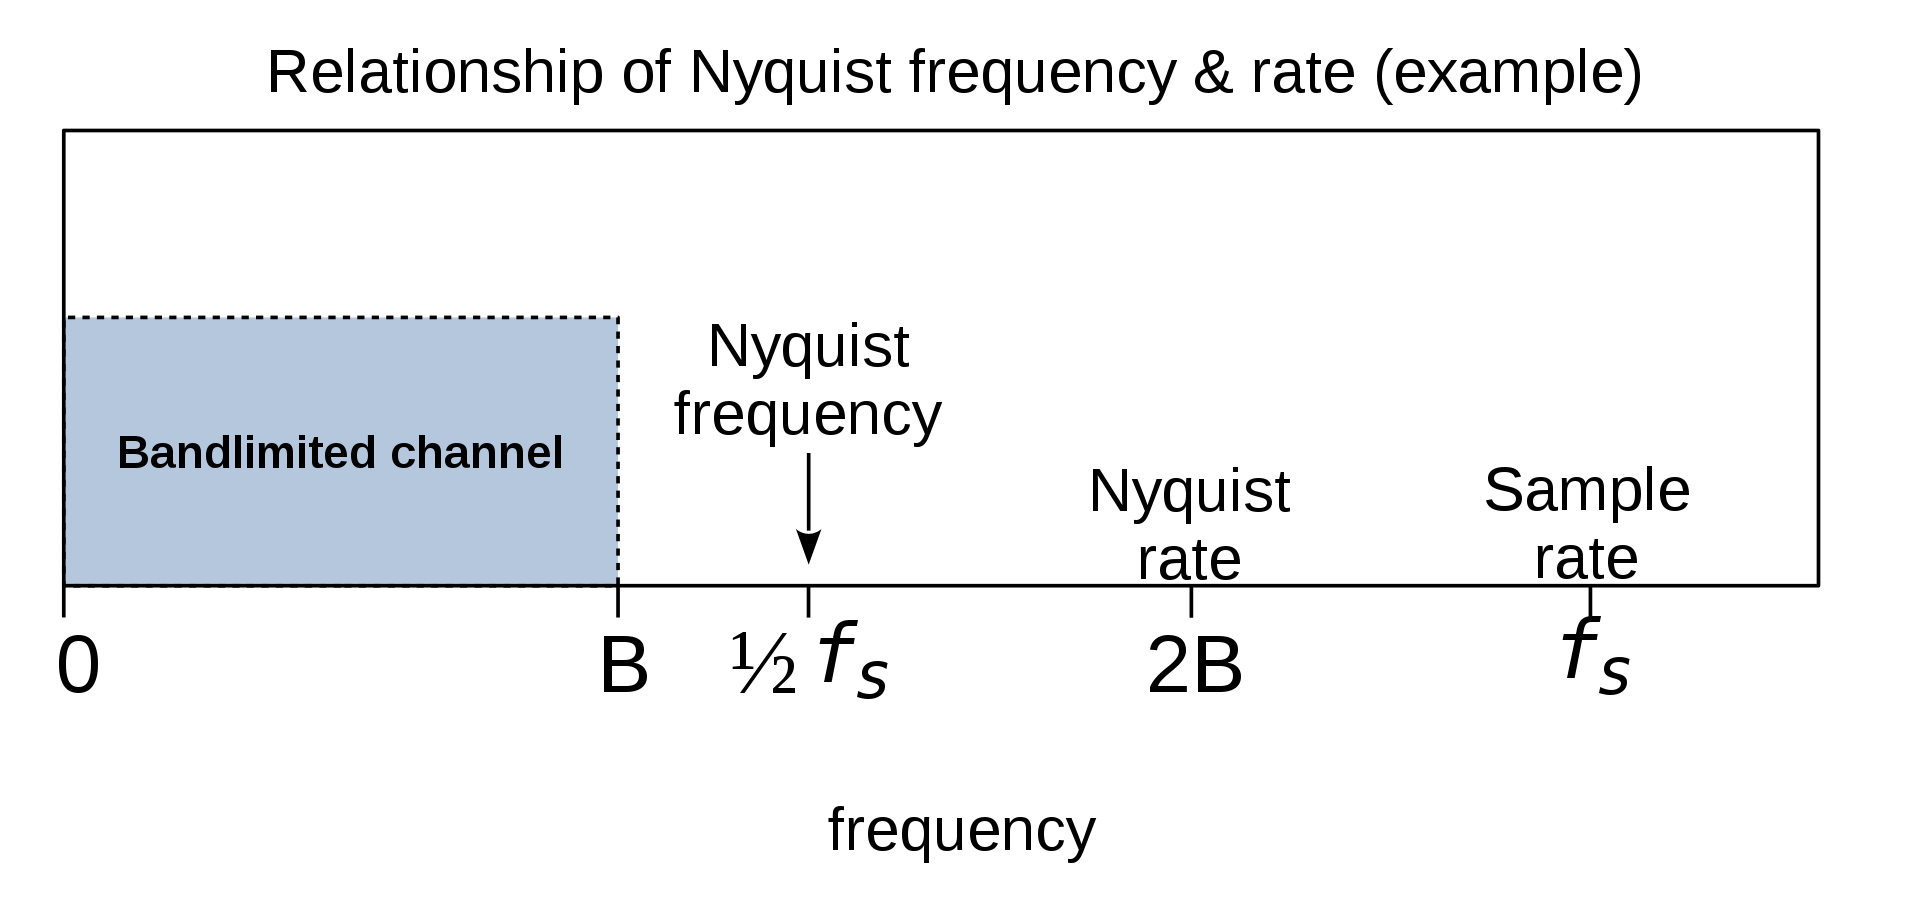

<center>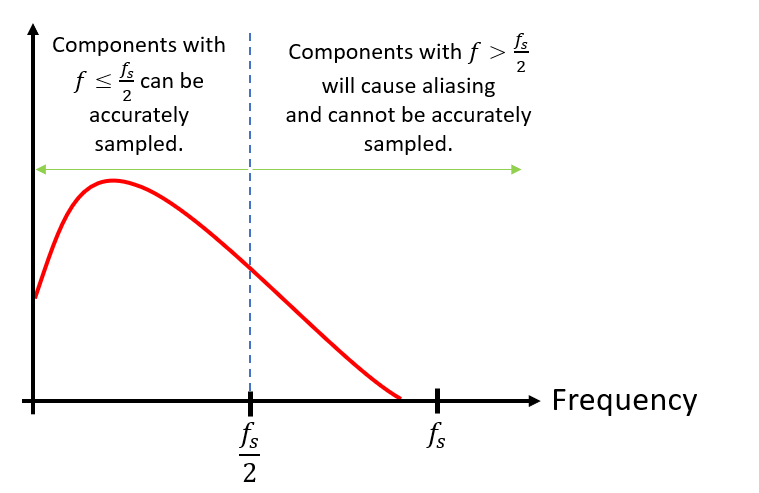
    

For a given sample rate, the corresponding Nyquist frequency in Hz is the largest bandwidth that can be sampled without aliasing, and its value is one-half the sample-rate.

> 주어진 sample rate가 있을 때, aliasing(신호 복원시신호의 왜곡을 생기게하는 현상) 없는 가장 큰 주파수 대역폭은 sample_rate의 1/2배 이다.


In [7]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [8]:
class AudioDataset(Dataset):
    def __init__(self, audio_paths, labels, resample_rate=None, noises=None):
        self.audio_paths = audio_paths
        self.labels = labels
        self.resample_rate = resample_rate
        self.noises = noises
        
    def __len__(self):
        return len(self.audio_paths)
    
    def _add_noise(self, audio, noises, scale=0.5):
        if noises is not None:
            # Keras 예제 (batch 단위)와 달리 example 하나씩 noise 추가 -> dim=0 사용

            # Create a random tensor of the same size as audio ranging from
            # 0 to the number of noise stream samples that we have.
            torch_rand = torch.FloatTensor(1, ).uniform_(0, noises.shape[0]).to(torch.int32)
            
            noise = torch.index_select(noises, dim=0, index=torch_rand) # torch.Size([1, 16000, 1])
            noise = noise[0] # torch.Size([16000, 1])

            # Get the amplitude proportion between the audio and the noise
            # torch.max returns (max, max_indices), (https://pytorch.org/docs/stable/generated/torch.max.html)
            prop = torch.div(torch.max(audio, dim=0)[0], torch.max(noise, dim=0)[0]) # torch.Size([16000, 1])
            
            # Adding the rescaled noise to audio
            # Noise가 주가 되지 않게 rescaling
            audio = audio + noise * prop * scale
            
        return audio

    def _audio_to_fft(self, audio):
        # Since torch.fft.fft applies FFT on the one dimensional input,
        # we need to squeeze the dimensions and then expand them again
        # after FFT

        # https://pytorch.org/docs/stable/generated/torch.fft.fft.html#torch.fft.fft
        
        audio = torch.squeeze(audio) # torch.Size([1, 16000, 1]) -> torch.Size([16000])

        fft = torch.fft.fft(audio) # torch.Size([16000])
        fft = torch.unsqueeze(fft, dim=-1) # torch.Size([16000, 1])
        
        # Return the absolute value of the first half of the FFT
        # which represents the positive frequencies
        return torch.abs(fft[: (audio.shape[0] // 2), :]) # torch.Size([8000, 1])

    def __getitem__(self, idx):
        """Constructs a dataset of audios and labels."""
        audio, sample_rate = torchaudio.load(self.audio_paths[idx])
        
        if sample_rate:
            # waveform (Tensor) – Tensor of audio of dimension (…, time).
            audio_sample = torchaudio.transforms.Resample(sample_rate, self.resample_rate)(audio.view(1,-1))
        
        audio_sample = audio_sample.reshape(-1, 1)
        # Add noise to the training set
        if self.noises is not None:
             audio_sample = self._add_noise(audio_sample, self.noises)

        # Transform audio wave to the frequency domain using `audio_to_fft`
        audio_sample = self._audio_to_fft(audio_sample)
        
        label = self.labels[idx]
        
        return {'audio_sample' : audio_sample,
               'label': label}

In [9]:
# Get the list of audio file paths along with their corresponding labels

class_names = os.listdir(DATASET_AUDIO_PATH)
print("Our class names: {}".format(class_names,))

audio_paths = []
labels = []
for label, name in enumerate(class_names):
    print("Processing speaker {}".format(name,))
    dir_path = Path(DATASET_AUDIO_PATH) / name
    speaker_sample_paths = [
        os.path.join(dir_path, filepath)
        for filepath in os.listdir(dir_path)
        if filepath.endswith(".wav")
    ]
    audio_paths += speaker_sample_paths
    labels += [label] * len(speaker_sample_paths)

print(
    "Found {} files belonging to {} classes.".format(len(audio_paths), len(class_names))
)

# Shuffle
rng = np.random.RandomState(SHUFFLE_SEED)
rng.shuffle(audio_paths)
rng = np.random.RandomState(SHUFFLE_SEED)
rng.shuffle(labels)

# Split into training and validation
num_val_samples = int(VALID_SPLIT * len(audio_paths))
print("Using {} files for training.".format(len(audio_paths) - num_val_samples))
train_audio_paths = audio_paths[:-num_val_samples]
train_labels = labels[:-num_val_samples]

print("Using {} files for validation.".format(num_val_samples))
valid_audio_paths = audio_paths[-num_val_samples:]
valid_labels = labels[-num_val_samples:]

# Create 2 datasets, one for training and the other for validation

# Add noise to the training set (not add to the valid set)
train_dataset = AudioDataset(train_audio_paths, train_labels, resample_rate=SAMPLING_RATE, noises=noises)
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = AudioDataset(valid_audio_paths, valid_labels, resample_rate=SAMPLING_RATE, noises=None)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=True)

Our class names: ['Benjamin_Netanyau', 'Magaret_Tarcher', 'Julia_Gillard', 'Jens_Stoltenberg', 'Nelson_Mandela']
Processing speaker Benjamin_Netanyau
Processing speaker Magaret_Tarcher
Processing speaker Julia_Gillard
Processing speaker Jens_Stoltenberg
Processing speaker Nelson_Mandela
Found 7501 files belonging to 5 classes.
Using 6751 files for training.
Using 750 files for validation.


In [10]:
print(iter(train_loader).next()['audio_sample']) # torch.Size([128, 8000, 1])
print(iter(train_loader).next()['label']) # torch.Size([128])

tensor([[[1.8193e+01],
         [1.0979e+01],
         [1.1673e+01],
         ...,
         [1.0809e-01],
         [7.9131e-02],
         [6.3704e-02]],

        [[1.1253e+00],
         [4.7506e+00],
         [1.4682e+00],
         ...,
         [2.4740e-01],
         [2.4421e-01],
         [2.6185e-01]],

        [[4.1933e+01],
         [1.1189e+02],
         [3.6505e+02],
         ...,
         [1.0040e+00],
         [1.3687e+00],
         [2.1352e+00]],

        ...,

        [[6.1912e+00],
         [4.1574e+00],
         [3.5611e+00],
         ...,
         [3.5441e-02],
         [6.3439e-02],
         [5.4900e-02]],

        [[8.2883e+02],
         [3.5010e+02],
         [1.3812e+02],
         ...,
         [1.9961e-02],
         [1.5496e-02],
         [3.1338e-02]],

        [[6.9820e+00],
         [1.0358e+01],
         [1.6475e+01],
         ...,
         [4.5336e-01],
         [4.3900e-01],
         [3.8276e-01]]])
tensor([0, 2, 4, 3, 3, 2, 2, 4, 2, 3, 2, 2, 2, 3, 0, 2, 0, 4, 

# Model Definition

In [11]:
import torch.nn as nn

In [12]:
# https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/02-intermediate/deep_residual_network/main.py

# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, conv_num=3):
        super(ResidualBlock, self).__init__()
        self.conv_num = conv_num
        self.conv1d_1 = nn.Conv1d(in_channels, out_channels, kernel_size=1, padding=0)
        self.conv1d_3_1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1) # Residual block 내 첫번째 conv에서만 channel 2배
        self.conv1d_3_2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=2, stride=2)
        
    def forward(self, x):
        residual = self.conv1d_1(x) #  torch.Size([128, 16, 8000])
        out = torch.clone(x)
        # convolution block 반복 횟수
        for i in range(self.conv_num - 1):
            if i==0:
                out = self.conv1d_3_1(out)
            else:
                out = self.conv1d_3_2(out)
            out = self.relu(out)
        # out : torch.Size([128, 16, 8000])
        out = self.conv1d_3_2(out)
        out += residual
        out = self.relu(out)
        out = self.maxpool(out)
    
        return out

In [13]:
# ResNet
# layers = [2,2,3,3,3] 
# cf. 실제 conv 반복 횟수 [1,1,2,2,2]

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=5):
        super(ResNet, self).__init__()
        self.in_channels = 1
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1])
        self.layer3 = self.make_layer(block, 64, layers[2])
        self.layer4 = self.make_layer(block, 128, layers[3])
        self.layer5 = self.make_layer(block, 128, layers[4])

        self.avg_pool = nn.AvgPool1d(kernel_size=3, stride=3)
        self.relu = nn.ReLU(inplace=True)
        self.fc1= nn.Linear(10624, 256)
        self.fc2= nn.Linear(256, 128)
        self.fc3= nn.Linear(128, num_classes)
        
    def make_layer(self, block, out_channels, conv_num):
        layer=block(self.in_channels, out_channels, conv_num)
        
        # layer2 위해서 self.in_channels값 update.
        self.in_channels = out_channels
        
        return layer
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)

        out = self.avg_pool(out)
        out = out.view(out.size(0), -1) # flatten # torch.Size([128, 10624])
        out = self.fc1(out) # torch.Size([128, 256])
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out) # do not apply softmax
        return out

In [14]:
from tqdm.notebook import tqdm
from einops import rearrange

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
print ('Current device : ', device)

layers=[2,2,3,3,3]

model = ResNet(ResidualBlock, layers, num_classes=len(class_names)).to(device)

num_epochs=10 # 100
total_step = len(train_loader)
learning_rate = 0.0001 

criterion =  nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Current device :  cuda


In [15]:
# https://www.geeksforgeeks.org/training-neural-networks-with-validation-using-pytorch/
min_valid_loss = np.inf

for epoch in tqdm(range(0, num_epochs)):    
    for i_batch, sample_batched in enumerate(train_loader):
        
        batch_inputs = sample_batched['audio_sample'].to(device) # torch.Size([128, 8000, 1])
        batch_inputs = rearrange(batch_inputs, 'b l c -> b c l') # torch.Size([128, 1, 8000])
        batch_targets = sample_batched['label'].to(device) # torch.Size([128])

        # Forward
        outputs = model(batch_inputs) 
        
        # Compute loss
        loss = criterion(outputs, batch_targets) 
        
        
        # Backward
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if (i_batch+1)%10 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch+1, num_epochs, i_batch, total_step, loss.item())) 
       
    model.eval()
    with torch.no_grad():
        valid_loss = 0.0
        for i_batch, sample_batched in enumerate(val_loader):

            batch_inputs = sample_batched['audio_sample'].to(device) # torch.Size([128, 8000, 1])
            batch_inputs = rearrange(batch_inputs, 'b l c -> b c l') # torch.Size([128, 1, 8000])
            batch_targets = sample_batched['label'].to(device) # torch.Size([128])

            preds = model(batch_inputs)

            accuracy = sum(torch.argmax(preds, dim=1)==batch_targets)/len(batch_targets)
            loss = criterion(preds, batch_targets)
            valid_loss += loss.item()

        if min_valid_loss > valid_loss:
            print(f'Validation Accuracy : {accuracy * 100} %')
            print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) Saving The Model...')
            min_valid_loss = valid_loss

            # Save the model checkpoints
            torch.save(model.state_dict(), './models/speaker_recognition-{}.ckpt'.format(epoch+1))
        
    model.train()



Epoch [1/10], Step [9/53], Loss: 1.2036
Epoch [1/10], Step [19/53], Loss: 0.7932
Epoch [1/10], Step [29/53], Loss: 0.5845
Epoch [1/10], Step [39/53], Loss: 0.5328
Epoch [1/10], Step [49/53], Loss: 0.4958
Validation Accuracy : 92.85714721679688 %
Validation Loss Decreased(inf--->7.147054) Saving The Model...
Epoch [2/10], Step [9/53], Loss: 0.3950
Epoch [2/10], Step [19/53], Loss: 0.3125
Epoch [2/10], Step [29/53], Loss: 0.2407
Epoch [2/10], Step [39/53], Loss: 0.3293
Epoch [2/10], Step [49/53], Loss: 0.2943
Validation Accuracy : 100.0 %
Validation Loss Decreased(7.147054--->5.164782) Saving The Model...
Epoch [3/10], Step [9/53], Loss: 0.1638
Epoch [3/10], Step [19/53], Loss: 0.4397
Epoch [3/10], Step [29/53], Loss: 0.3768
Epoch [3/10], Step [39/53], Loss: 0.2367
Epoch [3/10], Step [49/53], Loss: 0.2424
Validation Accuracy : 78.5714340209961 %
Validation Loss Decreased(5.164782--->4.461008) Saving The Model...
Epoch [4/10], Step [9/53], Loss: 0.2096
Epoch [4/10], Step [19/53], Loss: 0.

# Demonstration

Let's take some samples and:

- Predict the speaker
- Compare the prediction with the real speaker
- Listen to the audio to see that despite the samples being noisy,
the model is still pretty accurate

In [16]:
# Inference에서 푸리에 변환이 되지 않은 [16000, 1]의 audio를 사용하기 위함
# 위에 AudioDataset은 training을 위해 푸리에 변환된 input을 생성하도록 정의했음

class TestAudioDataset(Dataset):
    def __init__(self, audio_paths, labels, resample_rate=None, noises=None):
        self.audio_paths = audio_paths
        self.labels = labels
        self.resample_rate = resample_rate
        self.noises = noises
        
    def __len__(self):
        return len(self.audio_paths)
    
    def _add_noise(self, audio, noises, scale=0.5):
        if noises is not None:

            torch_rand = torch.FloatTensor(1, ).uniform_(0, noises.shape[0]).to(torch.int32)
            
            noise = torch.index_select(noises, dim=0, index=torch_rand) # torch.Size([1, 16000, 1])
            noise = noise[0] # torch.Size([16000, 1])

            # Get the amplitude proportion between the audio and the noise
            prop = torch.div(torch.max(audio, dim=0)[0], torch.max(noise, dim=0)[0]) # torch.Size([16000, 1])
            
            # Adding the rescaled noise to audio
            audio = audio + noise * prop * scale
        return audio

    def _audio_to_fft(self, audio):

        audio = torch.squeeze(audio) # torch.Size([1, 16000, 1]) -> torch.Size([16000])

        fft = torch.fft.fft(audio) # torch.Size([16000])
        fft = torch.unsqueeze(fft, dim=-1) # torch.Size([16000, 1])
        
        # Return the absolute value of the first half of the FFT
        # which represents the positive frequencies
        return torch.abs(fft[: (audio.shape[0] // 2), :]) # torch.Size([8000, 1])

    def __getitem__(self, idx):
        """Constructs a dataset of audios and labels."""
        audio, sample_rate = torchaudio.load(self.audio_paths[idx])
        
        if sample_rate:
            # waveform (Tensor) – Tensor of audio of dimension (…, time).
            audio_sample = torchaudio.transforms.Resample(sample_rate, self.resample_rate)(audio.view(1,-1))
        
        audio_sample = audio_sample.reshape(-1, 1)

        if self.noises is not None:
             audio_sample = self._add_noise(audio_sample, self.noises)
        
        audio_sample_16000 = torch.clone(audio_sample)
        audio_sample = self._audio_to_fft(audio_sample)
        
        label = self.labels[idx]
        
        return {'audio_sample_8000' : audio_sample,
                'audio_sample_16000' : audio_sample_16000,
               'label': label}

In [17]:
test_dataset = TestAudioDataset(valid_audio_paths, valid_labels, resample_rate=SAMPLING_RATE, noises=noises)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=True)

In [18]:
model = ResNet(ResidualBlock, layers, num_classes=len(class_names))
model.load_state_dict(torch.load('./models/speaker_recognition-10.ckpt', map_location='cpu'))
model.eval()

ResNet(
  (layer1): ResidualBlock(
    (conv1d_1): Conv1d(1, 16, kernel_size=(1,), stride=(1,))
    (conv1d_3_1): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv1d_3_2): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): ResidualBlock(
    (conv1d_1): Conv1d(16, 32, kernel_size=(1,), stride=(1,))
    (conv1d_3_1): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv1d_3_2): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): ResidualBlock(
    (conv1d_1): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
    (conv1d_3_1): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv1d_3_2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (relu

In [19]:
SAMPLES_TO_DISPLAY = 10

for i, sample_batched in enumerate(test_loader):

    batch_inputs = sample_batched['audio_sample_8000'].to('cpu') # torch.Size([128, 8000, 1])
    batch_inputs = rearrange(batch_inputs, 'b l c -> b c l') # torch.Size([128, 1, 8000])
    batch_targets = sample_batched['label'].to('cpu') # torch.Size([128])

    # Predict
    y_pred = model(batch_inputs).detach().numpy()
    
    # Take random samples
    rnd = np.random.randint(0, 32, SAMPLES_TO_DISPLAY)
    
    audios = sample_batched['audio_sample_16000'].to('cpu')
    audios = audios.numpy()[rnd, :, :]
    labels = batch_targets.numpy()[rnd]
    y_pred = np.argmax(y_pred, axis=-1)[rnd]

    for index in range(SAMPLES_TO_DISPLAY):
        # For every sample, print the true and predicted label
        # as well as run the voice with the noise
        print(
            "Speaker:\33{} {}\33[0m\tPredicted:\33{} {}\33[0m".format(
                "[92m" if labels[index] == y_pred[index] else "[91m",
                class_names[labels[index]],
                "[92m" if labels[index] == y_pred[index] else "[91m",
                class_names[y_pred[index]],
            )
        )
        audios = rearrange(audios, 'b c l -> b l c ') 
        display(Audio(audios[index, :, :].squeeze(), rate=SAMPLING_RATE))
    break

Speaker: Benjamin_Netanyau	Predicted: Benjamin_Netanyau


Speaker: Nelson_Mandela	Predicted: Nelson_Mandela


Speaker: Benjamin_Netanyau	Predicted: Benjamin_Netanyau


Speaker: Nelson_Mandela	Predicted: Nelson_Mandela


Speaker: Julia_Gillard	Predicted: Julia_Gillard


Speaker: Julia_Gillard	Predicted: Julia_Gillard


Speaker: Benjamin_Netanyau	Predicted: Jens_Stoltenberg


Speaker: Nelson_Mandela	Predicted: Nelson_Mandela


Speaker: Jens_Stoltenberg	Predicted: Benjamin_Netanyau


Speaker: Nelson_Mandela	Predicted: Nelson_Mandela
